In [23]:
import torch
from torch import nn
from ultralytics import YOLO
import os
# os.environ["KERAS_BACKEND"] = "torch"
import keras
import tensorflow as tf
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
from collections import defaultdict
from pathlib import Path
from sinar.utils import get_xyid, to_dict

In [ ]:
def build_model(do_c=0, do_fc=0):

    inp = tf.keras.layers.Input((30, 30))
    x = tf.keras.layers.Reshape((30, 30, 1))(inp)

    conv1 = tf.keras.layers.Conv2D(16, kernel_size=(1,2), strides=(1,2))(x)
    conv1 = tf.keras.layers.Activation('relu')(conv1)

    conv2 = tf.keras.layers.Conv2D(16, kernel_size=(2,1), strides=(2,1))(conv1)
    conv2 = tf.keras.layers.Activation('relu')(conv2)

    do1 = tf.keras.layers.Dropout(do_c)(conv2)

    conv3 = tf.keras.layers.Conv2D(16, kernel_size=5, strides=1)(do1)
    conv3 = tf.keras.layers.Activation('relu')(conv3)

    full = tf.keras.layers.GlobalAveragePooling2D()(conv3)
    do2 = tf.keras.layers.Dropout(do_fc)(full)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(do2)

    cnn4 = tf.keras.models.Model(inputs=inp, outputs=out)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    cnn4.compile(loss="binary_crossentropy",
                    optimizer=optimizer,
                    metrics=['accuracy'])
    
    return cnn4


In [4]:
keras_model = tf.keras.models.load_model(rf"H:\My Drive\runs\documentations\CNN1-set-D49\best.keras")
keras_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 15, 16)     │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 15, 15, 16)     │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,029 (82.15 KB)

 Trainable params: 7,009 (27.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,020 (54.77 KB)

In [29]:
keras_model.weights

[<KerasVariable shape=(1, 2, 1, 16), dtype=float32, path=conv2d/kernel>,
 <KerasVariable shape=(16,), dtype=float32, path=conv2d/bias>,
 <KerasVariable shape=(2, 1, 16, 16), dtype=float32, path=conv2d_1/kernel>,
 <KerasVariable shape=(16,), dtype=float32, path=conv2d_1/bias>,
 <KerasVariable shape=(5, 5, 16, 16), dtype=float32, path=conv2d_2/kernel>,
 <KerasVariable shape=(16,), dtype=float32, path=conv2d_2/bias>,
 <KerasVariable shape=(16, 1), dtype=float32, path=dense/kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=dense/bias>]

In [35]:
keras_model.weights[0].shape

TensorShape([1, 2, 1, 16])

In [37]:
keras_model.weights[0].numpy()

array([[[[   -0.19783,     0.21856,    -0.18722,    -0.18733,    -0.18463,     0.44681,     0.94512,     0.91607,    0.043627,   -0.025573,     -0.0121,     0.78389,    0.052948,     0.75834,     0.52965,   -0.058162]],

        [[    0.43045,     0.21054,    -0.19604,    -0.19198,    -0.25621,    -0.39193,     0.75421,   0.0015345,    -0.48218,    -0.45289,     0.46417,     0.13988,     0.52352,    -0.42818,    -0.24307,     0.39482]]]], dtype=float32)

In [38]:
keras_model.weights[0][0, :, 0,0].numpy()

array([   -0.19783,     0.43045], dtype=float32)

In [13]:
class MotasClassifier(nn.Module):
    def __init__(self, do_c=0, do_fc=0):
        super(MotasClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 2), stride=(1, 2))
        self.conv2 = nn.Conv2d(16, 16, kernel_size=(2, 1), stride=(2, 1))
        self.conv3 = nn.Conv2d(16, 16, kernel_size=5, stride=1)
        self.dropout_c = nn.Dropout(do_c)
        self.dropout_fc = nn.Dropout(do_fc)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = x.view(-1, 1, None, None)  # Reshape input
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.dropout_c(x)
        x = torch.relu(self.conv3(x))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout_fc(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
    
    @classmethod
    def from_keras(cls, keras_model_path):
        keras_model = tf.keras.models.load_model(keras_model_path)
        model = cls()
        model.load_keras_weights(keras_model.weights)
        return model
    
    def load_keras_weights(self, keras_weights):
        self.conv1.weight.data = torch.tensor(keras_weights[0].numpy().transpose(3, 2, 0, 1))
        self.conv1.bias.data = torch.tensor(keras_weights[1].numpy())
        self.conv2.weight.data = torch.tensor(keras_weights[2].numpy().transpose(3, 2, 0, 1))
        self.conv2.bias.data = torch.tensor(keras_weights[3].numpy())
        self.conv3.weight.data = torch.tensor(keras_weights[4].numpy().transpose(3, 2, 0, 1))
        self.conv3.bias.data = torch.tensor(keras_weights[5].numpy())
        self.fc.weight.data = torch.tensor(keras_weights[6].numpy().transpose(1, 0))
        self.fc.bias.data = torch.tensor(keras_weights[7].numpy())

In [14]:
torch_model = MotasClassifier()
# torch_model.load_keras_weights(keras_model.weights)

In [15]:
torch_model.eval()


MotasClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(1, 2), stride=(1, 2))
  (conv2): Conv2d(16, 16, kernel_size=(2, 1), stride=(2, 1))
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout_c): Dropout(p=0, inplace=False)
  (dropout_fc): Dropout(p=0, inplace=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [20]:
m12 = torch.rand(1, 12, 12)
m20 = torch.rand(1, 20, 20)
m30 = torch.rand(1, 30, 30)

stack = torch.stack([m12, m12, m12], dim=0)
stack.shape

torch.Size([3, 1, 12, 12])

In [29]:
torch_model(torch.rand(1, 1, 130, 30))

tensor([[0.4829]], grad_fn=<SigmoidBackward0>)

In [18]:
random_input = torch.rand(1, 1, 20, 20)
output = torch_model(random_input)
output.shape

torch.Size([1, 1])

In [17]:
output

tensor([[0.4835]], grad_fn=<SigmoidBackward0>)

In [ ]:
class CentroidMatrixDataset(Dataset):
    def __init__(self, model_path: str):
        self.yolo = YOLO(model_path, task="detect")
        # Group data by their last dimension
        self.grouped_data = defaultdict(list)
        self.grouped_list = [ # list of batch size index
            (key, idx) for key in self.grouped_data.keys() for idx in range(len(self.grouped_data[key]))
        ]

    def __len__(self):
        return len(self.grouped_list)

    def __getitem__(self, idx):
        group_key, item_idx = self.grouped_list[idx]
        return self.grouped_data[group_key][item_idx], group_key
    


    def create_matrices_from_videos(self, video_path: str):         
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        rows = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            res = self.yolo.track(frame, verbose=False, 
                            stream_buffer=True, 
                            persist=True, vid_stride=True, 
                            tracker="bytetrack.yaml")[0]
            if res.boxes.id is None:
                rows.append({})
                continue
            ids, xy = get_xyid(res.boxes)
            rows.append(to_dict(ids, xy, flatten=True))
        cap.release()
        self.yolo.predictor.trackers[0].reset() # Reset the tracker

        matrices = []
        for start_point in range(0, total_frames, 5):
            for start_frame in range(start_point, start_point+5):
                matrix = []
                for i in range(30):
                    frame_idx = start_frame + i * 5
                    if frame_idx >= total_frames:
                        matrix.append({})
                        continue
                    matrix.append(rows[frame_idx])
                df = pd.DataFrame(matrix)
                df.fillna(0, inplace=True)
                matrix = df.values
                matrices.append(matrix)
            if start_frame + (30 - 1) * 5 >= total_frames:
                break
        
        for matrix in matrices:
            self.grouped_data[matrix.shape[-1]].append(matrix)


In [3]:
from torch.utils.data import Sampler

class GroupedBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.group_indices = defaultdict(list)
        for idx, (_, group_key) in enumerate(dataset):
            self.group_indices[group_key].append(idx)

    def __iter__(self):
        for group_key, indices in self.group_indices.items():
            # Yield batches from each group
            for i in range(0, len(indices), self.batch_size):
                yield indices[i:i + self.batch_size]

    def __len__(self):
        return sum((len(indices) + self.batch_size - 1) // self.batch_size
                   for indices in self.group_indices.values())


In [6]:
# Sample data with varying last dimensions (12, 20, 30)
import random
data = [torch.rand(1, 30, x) for _ in range(10) for x in random.choices([12, 20, 30, 100], k=3)]

# Create the dataset and sampler
grouped_dataset = GroupedDataset(data)
batch_sampler = GroupedBatchSampler(grouped_dataset, batch_size=15)

# Create DataLoader
dataloader = DataLoader(grouped_dataset, batch_sampler=batch_sampler)

# Iterate through the DataLoader
for batch in dataloader:
    samples, group_key = batch
    print(f"Group {group_key[0]}: {samples.shape}")


Group 30: torch.Size([9, 1, 30, 30])
Group 100: torch.Size([11, 1, 30, 100])
Group 12: torch.Size([4, 1, 30, 12])
Group 20: torch.Size([6, 1, 30, 20])


In [10]:
len(grouped_dataset.grouped_data[30])

9

In [39]:
for d in data:
    print(d.shape)

torch.Size([1, 1, 20, 12])
torch.Size([1, 1, 20, 20])
torch.Size([1, 1, 20, 20])
torch.Size([1, 1, 20, 30])
torch.Size([1, 1, 20, 30])
torch.Size([1, 1, 20, 30])
torch.Size([1, 1, 20, 12])
torch.Size([1, 1, 20, 30])
torch.Size([1, 1, 20, 20])
torch.Size([1, 1, 20, 20])
torch.Size([1, 1, 20, 30])
torch.Size([1, 1, 20, 20])
torch.Size([1, 1, 20, 12])
torch.Size([1, 1, 20, 20])
torch.Size([1, 1, 20, 12])
torch.Size([1, 1, 20, 30])
torch.Size([1, 1, 20, 12])
torch.Size([1, 1, 20, 12])
torch.Size([1, 1, 20, 12])
torch.Size([1, 1, 20, 20])
torch.Size([1, 1, 20, 20])
torch.Size([1, 1, 20, 12])
torch.Size([1, 1, 20, 20])
torch.Size([1, 1, 20, 20])
torch.Size([1, 1, 20, 12])
torch.Size([1, 1, 20, 30])
torch.Size([1, 1, 20, 30])
torch.Size([1, 1, 20, 20])
torch.Size([1, 1, 20, 30])
torch.Size([1, 1, 20, 20])


In [52]:
for batch in dataloader:
    samples, group_key = batch
    out = torch_model(samples)
    print(f"group_key: {group_key[0]}, out: {out.shape}, samples: {samples.shape}")

group_key: 12, out: torch.Size([11, 1]), samples: torch.Size([11, 1, 30, 12])
group_key: 20, out: torch.Size([4, 1]), samples: torch.Size([4, 1, 30, 20])
group_key: 30, out: torch.Size([7, 1]), samples: torch.Size([7, 1, 30, 30])
group_key: 100, out: torch.Size([8, 1]), samples: torch.Size([8, 1, 30, 100])


In [56]:
from torchsummary import summary

summary(torch_model, (1, 30, 30))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 15]              48
            Conv2d-2           [-1, 16, 15, 15]             528
           Dropout-3           [-1, 16, 15, 15]               0
            Conv2d-4           [-1, 16, 11, 11]           6,416
 AdaptiveAvgPool2d-5             [-1, 16, 1, 1]               0
           Dropout-6                   [-1, 16]               0
            Linear-7                    [-1, 1]              17
           Sigmoid-8                    [-1, 1]               0
Total params: 7,009
Trainable params: 7,009
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.03
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


In [6]:
torch_model = MotasClassifier.from_keras(rf"H:\My Drive\runs\documentations\CNN1-set-D49\best.keras")
torch_model

MotasClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(1, 2), stride=(1, 2))
  (conv2): Conv2d(16, 16, kernel_size=(2, 1), stride=(2, 1))
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout_c): Dropout(p=0, inplace=False)
  (dropout_fc): Dropout(p=0, inplace=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [16]:
torch.save(torch_model.state_dict(), rf"models\motas_classifier.pth")

In [17]:
loaded_model = torch.load(rf"models\motas_classifier.pth")
loaded_model

OrderedDict([('conv1.weight',
              tensor([[[[-0.1978,  0.4304]]],
              
              
                      [[[ 0.2186,  0.2105]]],
              
              
                      [[[-0.1872, -0.1960]]],
              
              
                      [[[-0.1873, -0.1920]]],
              
              
                      [[[-0.1846, -0.2562]]],
              
              
                      [[[ 0.4468, -0.3919]]],
              
              
                      [[[ 0.9451,  0.7542]]],
              
              
                      [[[ 0.9161,  0.0015]]],
              
              
                      [[[ 0.0436, -0.4822]]],
              
              
                      [[[-0.0256, -0.4529]]],
              
              
                      [[[-0.0121,  0.4642]]],
              
              
                      [[[ 0.7839,  0.1399]]],
              
              
                      [[[ 0.0529,  0.5235]]],
            

In [27]:
keras_model.layers

NameError: name 'keras_model' is not defined

In [11]:
# print the weights of the model
for name, param in torch_model.named_parameters():
    print(name, param.shape)

conv1.weight torch.Size([16, 1, 1, 2])
conv1.bias torch.Size([16])
conv2.weight torch.Size([16, 16, 2, 1])
conv2.bias torch.Size([16])
conv3.weight torch.Size([16, 16, 5, 5])
conv3.bias torch.Size([16])
fc.weight torch.Size([1, 16])
fc.bias torch.Size([1])


In [19]:
import numpy as np
np.random.rand(30, 640, 640, 3).nbytes

294912000

In [17]:
torch_model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.1978,  0.4304]]],
              
              
                      [[[ 0.2186,  0.2105]]],
              
              
                      [[[-0.1872, -0.1960]]],
              
              
                      [[[-0.1873, -0.1920]]],
              
              
                      [[[-0.1846, -0.2562]]],
              
              
                      [[[ 0.4468, -0.3919]]],
              
              
                      [[[ 0.9451,  0.7542]]],
              
              
                      [[[ 0.9161,  0.0015]]],
              
              
                      [[[ 0.0436, -0.4822]]],
              
              
                      [[[-0.0256, -0.4529]]],
              
              
                      [[[-0.0121,  0.4642]]],
              
              
                      [[[ 0.7839,  0.1399]]],
              
              
                      [[[ 0.0529,  0.5235]]],
            

In [37]:
class SinarModel(nn.Module):
    def __init__(self, model_path, device="cpu", auto_load=True):
        super(SinarModel, self).__init__()
        self.model_path = model_path
        self.device = device
        self.yolo = YOLO("", task="detect") # empty yolo model
        self.motas = MotasClassifier()
        self._load(model_path)
    
    def save(self, filename, use_dill=True):
        from copy import deepcopy
        from datetime import datetime
        saves = {
            "model": deepcopy(self.yolo.model).half(),
            "motas_state_dict": self.motas.state_dict(),
            "timestamp": datetime.now().isoformat()
        }
        torch.save(saves, filename, use_dill=use_dill)
    
    def _load(self, filename):
        from ultralytics.nn.tasks import attempt_load_one_weight
        model, ckpt = attempt_load_one_weight(filename, device=self.device)
        self.yolo.model = model
        if "motas_state_dict" in ckpt:
            self.motas.load_state_dict(ckpt["motas_state_dict"])
            self.motas.eval()
        else:
            print("No motas state dict found in the checkpoint.")
            print("please load the motas model manually from keras by calling load_motas_from_keras().")
    
    def load_motas_from_keras(self, model_path):
        m = tf.keras.models.load_model(model_path)
        self.motas.load_keras_weights(m.weights)
        self.motas.eval()
    
    # def predict(self, source):
    #     yolo_result_generator = self.yolo.track(source, stream=True)
    #     frame_idx = 0
    #     for result in yolo_result_generator:
            

    



In [29]:
yolo_path = rf"G:\My Drive\yolov8\train\yolov9m-all-data-fix\weights\best.pt"
keras_path = rf"H:\My Drive\runs\documentations\CNN1-set-D49\best.keras"
sinar = SinarModel(yolo_path)
sinar.load_motas_from_keras(keras_path)
sinar

No motas state dict found in the checkpoint.
please load the motas model manually from keras by calling load_motas_from_keras().


SinarModel(
  (yolo): YOLO(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (2): RepNCSPELAN4(
          (cv1): Conv(
            (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (cv2): Sequential(
            (0): RepCSP(
              (cv1): Conv(
                (conv): Conv2d(64, 32

In [30]:
sinar.save(rf"models\sinar_model.pt")

In [63]:
res = sinar.yolo.track(rf"G:\My Drive\dataset\video\trim\train\normal-3.011.mp4", stream=True)

In [ ]:
import cv2

for r in res:
    cv2.imshow("res", r.plot())
    if cv2.waitKey(1) == ord('q'):
        break
cv2.destroyAllWindows()


video 1/1 (frame 1/120) G:\My Drive\dataset\video\trim\train\normal-3.011.mp4: 384x640 4 motors, 536.9ms
video 1/1 (frame 2/120) G:\My Drive\dataset\video\trim\train\normal-3.011.mp4: 384x640 4 motors, 444.0ms
video 1/1 (frame 3/120) G:\My Drive\dataset\video\trim\train\normal-3.011.mp4: 384x640 3 motors, 418.9ms
video 1/1 (frame 4/120) G:\My Drive\dataset\video\trim\train\normal-3.011.mp4: 384x640 4 motors, 411.4ms
video 1/1 (frame 5/120) G:\My Drive\dataset\video\trim\train\normal-3.011.mp4: 384x640 5 motors, 431.4ms
video 1/1 (frame 6/120) G:\My Drive\dataset\video\trim\train\normal-3.011.mp4: 384x640 5 motors, 380.8ms
video 1/1 (frame 7/120) G:\My Drive\dataset\video\trim\train\normal-3.011.mp4: 384x640 5 motors, 389.5ms
video 1/1 (frame 8/120) G:\My Drive\dataset\video\trim\train\normal-3.011.mp4: 384x640 5 motors, 344.3ms
video 1/1 (frame 9/120) G:\My Drive\dataset\video\trim\train\normal-3.011.mp4: 384x640 5 motors, 396.9ms
video 1/1 (frame 10/120) G:\My Drive\dataset\video\tri

In [38]:
sinar = SinarModel(rf"models\sinar_model.pt")
sinar

SinarModel(
  (yolo): YOLO(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (2): RepNCSPELAN4(
          (cv1): Conv(
            (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (cv2): Sequential(
            (0): RepCSP(
              (cv1): Conv(
                (conv): Conv2d(64, 32

In [31]:
sinar

SinarModel(
  (yolo): YOLO(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): RepNCSPELAN4(
          (cv1): Conv(
            (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Sequential(
            (0): RepCSP(
              (cv1): Conv(
                (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
                (act): SiLU(inplace=True)
              )
              (cv2): Conv(
                (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
                (act): SiLU(inplace=True)
              )
              (cv3): Conv(
                (conv): Conv2d(64, 64, kernel_siz

In [41]:
# check motas model is trainable
for name, param in sinar.motas.named_parameters():
    print(name, param.requires_grad)

conv1.weight True
conv1.bias True
conv2.weight True
conv2.bias True
conv3.weight True
conv3.bias True
fc.weight True
fc.bias True


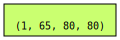

In [56]:
# plot layer connection of torch module
from torchviz import make_dot

x = torch.randn(1, 3, 640, 640)
y = sinar.yolo.model(x)[1][0]
make_dot(y, params=dict(sinar.yolo.model.named_parameters()))

In [54]:
y[1][1].shape

torch.Size([1, 65, 40, 40])

In [13]:
yolo = YOLO("")

WARNING  Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


In [15]:
yolo

YOLO()

In [16]:
yolo.model_name

''

In [14]:
yolo.predictor is None

True

In [2]:
def cantor_pair(x, y):
    return (x + y) * (x + y + 1) // 2 + y

In [1]:
cantor_pair(1, 2)

NameError: name 'cantor_pair' is not defined

In [26]:
cantor_pair(2, 1)

7